<a href="https://colab.research.google.com/github/NVREND/MSIB-Hacktiv8-AI---CySec/blob/main/Assignment4NLPsmsSpamClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Assignment using LSTM
## SMS Spam Classification
* Nama: Endritha Pramudya
* Nama Mentor: Nikki Satmaka

The goal of this project is to develop a machine learning model capable of classifying text messages as 'ham' or 'spam' with a high degree of accuracy using LSTM.   The model will also be evaluated based on evaluation metrics such as precision, recall, F1 score, and accuracy to ensure the model can reliably detect spam messages while maintaining minimal error rates.

This project uses dataset from kaggle https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset/data

## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
nltk.download('stopwords')

import os
import json
from google.colab import files

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Data Loading

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d uciml/sms-spam-collection-dataset

Dataset URL: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset
License(s): unknown
100% 211k/211k [00:00<00:00, 1.12MB/s]
100% 211k/211k [00:00<00:00, 1.11MB/s]


In [ ]:
!unzip sms-spam-collection-dataset.zip

Archive:  sms-spam-collection-dataset.zip
  inflating: spam.csv                


In [ ]:
df = pd.read_csv('spam.csv', encoding='latin1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
df.shape

(5572, 5)

## Data Cleaning & EDA

In [ ]:
# Remove unnecessary columns
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)

In [ ]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# Replace columns
replace_columns={
    'v1':'label',
    'v2':'message'
}

df.rename(columns=replace_columns,inplace=True)

In [ ]:
df.label.unique()

array(['ham', 'spam'], dtype=object)

In [ ]:
# check for duplicate values
df.duplicated().sum()

403

It can be seen that there are 403 duplicate values

In [ ]:
# Drop duplicate values
df=df.drop_duplicates()

In [ ]:
df['label'].value_counts()

label
ham     4516
spam     653
Name: count, dtype: int64

It can be seen that there are 4516 ham messages and 653 spam messages

## Split the Dataset

In [ ]:
messages = df['message']
labels = df['label']

In [ ]:
# Convert labels to binary (0 for 'ham', 1 for 'spam')
labels = labels.map({'ham': 0, 'spam': 1})

# Determine the size of the training data
training_size = int(len(messages) * 0.8)

# Split the message
training_messages = messages[:training_size]
testing_messages = messages[training_size:]

# Split the labels
training_labels = labels[:training_size]
testing_labels = labels[training_size:]

In [ ]:
print(f"There are {len(training_messages)} messages for training.\n")
print(f"There are {len(training_labels)} labels for training.\n")
print(f"There are {len(testing_messages)} messages for Testing.\n")
print(f"There are {len(testing_labels)} labels for testing.")

There are 4135 messages for training.

There are 4135 labels for training.

There are 1034 messages for Testing.

There are 1034 labels for testing.


## Data Preprocessing

In [ ]:
def messages_preprocessing(messages):

    # Case folding: Convert to lowercase
    messages = messages.lower()

    # Mention removal
    messages = re.sub(r"@[A-Za-z0-9_]+", " ", messages)

    # URL removal
    messages = re.sub(r"http\S+|www\S+|https\S+", '', messages, flags=re.MULTILINE)

    # Punctuation removal
    messages = re.sub(r'[^\w\s]', ' ', messages)

    # Digit removal
    messages = re.sub(r'\d+', '', messages)

    # Extra whitespace removal
    messages = re.sub(r'\s+', ' ', messages).strip()

    # Remove Stopwords
    # Retrieve a list of English stopwords
    stop_words = set(stopwords.words('english'))
    # Sentence converted to lowercase-only
    words = messages.lower().split()
    # Remove stopwords and rejoin the words
    filtered_words = [word for word in words if word not in stop_words]
    filtered_messages = ' '.join(filtered_words)

    return filtered_messages

# Test the function
example_messages = messages.iloc[0]
preprocessed_messages = messages_preprocessing(example_messages)
print("Original Message:", example_messages)
print("Preprocessed Sentence:", preprocessed_messages)

Original Message: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Preprocessed Sentence: go jurong point crazy available bugis n great world la e buffet cine got amore wat


## Tokenization and Padding

In [ ]:
vocab_size = 10000
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

# Initialize tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(messages)

# Generate the word index dictionary
tokenizer.fit_on_texts(training_messages)
word_index = tokenizer.word_index

# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(training_messages)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the testing sequences
testing_sequences = tokenizer.texts_to_sequences(testing_messages)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Convert the labels lists into numpy arrays
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

## Model Building

In [ ]:
# Hyperparameters
embedding_dim = 16
lstm_dim = 32
dense_dim = 24

# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Model summary
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 bidirectional (Bidirection  (None, 64)                12544     
 al)                                                             
                                                                 
 dense (Dense)               (None, 24)                1560      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 174129 (680.19 KB)
Trainable params: 174129 (680.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Train the Model

In [ ]:
NUM_EPOCHS = 10
history_lstm = model_lstm.fit(training_padded, training_labels, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels))

Epoch 1/10
130/130 [==============================] - 20s 112ms/step - loss: 0.2934 - accuracy: 0.9042 - val_loss: 0.0644 - val_accuracy: 0.9826
Epoch 2/10
130/130 [==============================] - 12s 92ms/step - loss: 0.0466 - accuracy: 0.9874 - val_loss: 0.0451 - val_accuracy: 0.9855
Epoch 3/10
130/130 [==============================] - 11s 86ms/step - loss: 0.0211 - accuracy: 0.9947 - val_loss: 0.0426 - val_accuracy: 0.9884
Epoch 4/10
130/130 [==============================] - 13s 101ms/step - loss: 0.0108 - accuracy: 0.9973 - val_loss: 0.0475 - val_accuracy: 0.9884
Epoch 5/10
130/130 [==============================] - 14s 111ms/step - loss: 0.0039 - accuracy: 0.9995 - val_loss: 0.0549 - val_accuracy: 0.9884
Epoch 6/10
130/130 [==============================] - 13s 101ms/step - loss: 0.0030 - accuracy: 0.9995 - val_loss: 0.0502 - val_accuracy: 0.9913
Epoch 7/10
130/130 [==============================] - 12s 90ms/step - loss: 0.0018 - accuracy: 0.9995 - val_loss: 0.0589 - val_accur

## Model Evaluation

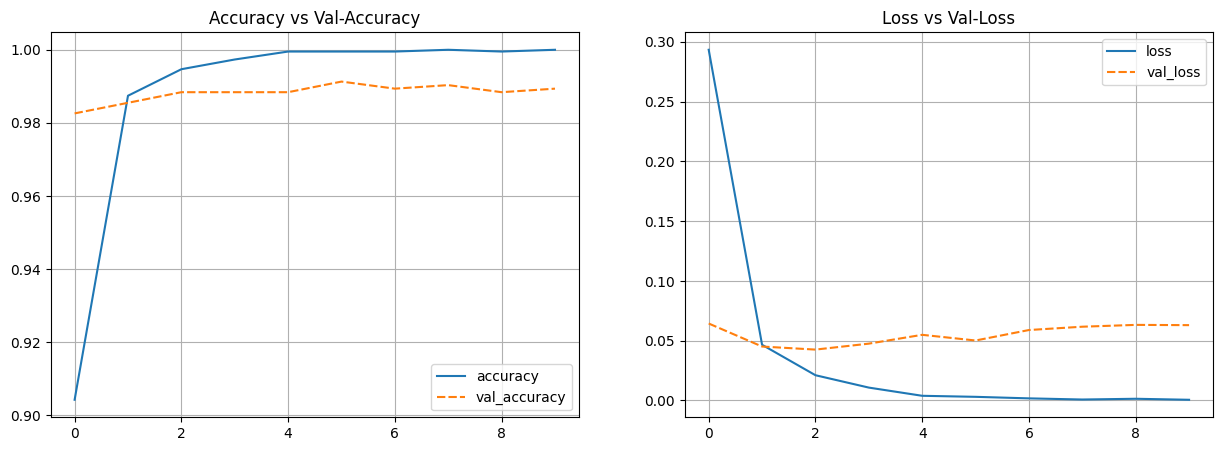

In [ ]:
import seaborn as sns

# Plot Training Results

history_lstm_df = pd.DataFrame(history_lstm.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_lstm_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_lstm_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

In [ ]:
# Evaluate the model on test data
loss, accuracy = model_lstm.evaluate(testing_padded, testing_labels, verbose=0)

print("Loss:", loss)
print("Accuracy:", accuracy)

Loss: 0.06302313506603241
Accuracy: 0.9893617033958435


From the model evaluation results, it can be seen that the model has a loss of around 0.05859 and an accuracy of around 98% on the test data.  This shows that the model has learned well from the training data, so it can make accurate predictions.  Even though accuracy is good, it is also necessary to consider additional metrics such as precision, recall, F1-score.

In [ ]:
from sklearn.metrics import classification_report

# Label prediction for test data
predictions = model_lstm.predict(testing_padded)

# Convert probabilities to class labels
predicted_labels = (predictions > 0.5).astype('int32')

# Report
print("Classification Report:")
print(classification_report(testing_labels, predicted_labels))

33/33 [==============================] - 1s 18ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       917
           1       0.98      0.92      0.95       117

    accuracy                           0.99      1034
   macro avg       0.99      0.96      0.97      1034
weighted avg       0.99      0.99      0.99      1034



Precision: The model has a precision of around 99% for class 'ham' (0) and approx 98% for class 'spam' (1).

Recall: The model has a recall of around 100% for the 'ham' class (0) and around 92% for the 'spam' class (1).  Shows that the model is able to identify the majority of examples that actually belong to each class.

F1-score: The F1-score value is around 99% for the 'ham' class (0) and around 95% for the 'spam' class (1).  F1-score is a weighted average of precision and recall, so it gives a good idea of ​​the balance between precision and recall.

Accuracy: The model's accuracy is approximately 99%, which is the overall percentage of correct predictions.

## Conclusion
The model that has been created has good performance in classifying 'ham' messages and 'spam' messages with good precision, recall, F1-score and accuracy.  This means that the model is reliable and can be used to detect 'spam' messages effectively.